In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load your dataset
df = pd.read_csv('expedia.csv')

# Overview of the dataset
print("Data Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

# Missing values analysis
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("\nMissing Values Analysis:\n", missing_df[missing_df['Missing Values'] > 0].sort_values(by='Percentage', ascending=False))

# Descriptive statistics
print("\nDescriptive Statistics for Numerical Features:\n", df.describe())
print("\nDescriptive Statistics for Categorical Features:\n", df.describe(include=['O']))

# Outlier detection for a sample feature (price_usd)
z_scores = zscore(df['price_usd'].dropna())
outliers = np.where(np.abs(z_scores) > 3)
print(f"\nNumber of Outliers in 'price_usd': {len(outliers[0])}")



Data Shape: (6622629, 50)

Data Types:
 srch_id                          int64
date_time                       object
site_id                          int64
visitor_location_country_id      int64
visitor_hist_starrating        float64
visitor_hist_adr_usd           float64
prop_country_id                  int64
prop_id                          int64
prop_starrating                  int64
prop_review_score              float64
prop_brand_bool                  int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
price_usd                      float64
promotion_flag                   int64
srch_destination_id              int64
srch_length_of_stay              int64
srch_booking_window              int64
srch_adults_count                int64
srch_children_count              int64
srch_room_count                  int64
srch_saturday_night_bool         int64
srch_query_affinity_score      float64
orig_destination_distanc

# Exploratory Data Analysis (EDA) Overview

## Initial Data Loading and Overview

The dataset, presumably from Expedia, comprises 6,622,629 records and 50 features, covering various aspects like search details, property information, and competitor comparisons. The features include a mix of numerical and categorical data types, ranging from IDs and ratings to price details and search parameters.

## Missing Values Analysis

A significant observation from the initial analysis is the presence of missing values across several features, notably within competitor rate percent differences and visitor historical data. For example, `comp1_rate_percent_diff` has 98.16% missing values, indicating a substantial lack of competitive rate data. This pattern suggests that competitor data is sparse or not consistently recorded.

## Descriptive Statistics

### Numerical Features
The descriptive statistics for numerical features reveal a wide range of values across different features. Key observations include:
- The `visitor_hist_starrating` has an average of 3.36, suggesting most historical hotel ratings fall within a mid to high range.
- The `price_usd` for hotel stays varies significantly, with some extreme values indicated by the standard deviation and maximum value.

### Categorical Features
The `date_time` feature, indicating the search date and time, shows a vast range of unique values, suggesting the dataset covers a broad timeframe.

## Outlier Analysis

The outlier analysis for `price_usd` identified 1,352 records with prices considered outliers based on a Z-score threshold greater than 3. This points to extreme variations in hotel pricing within the dataset, potentially influenced by factors like location, demand, or special events.

# Insights and Implications

The initial EDA highlights the complexity and richness of the Expedia dataset, underscoring the challenges in managing missing data, especially in competitive rate information. The outlier detection in hotel pricing further emphasizes the need for careful data cleaning and normalization, especially when preparing the data for modeling demand prediction.

Given the sparsity of certain features and the presence of outliers, subsequent steps will likely involve data imputation strategies, outlier handling, and feature engineering to develop a robust model for predicting hotel demand.


In [3]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame

# Step 1: Normalize search data to a single score
# This example uses a simple formula, but you might consider more complex scoring based on your understanding of the data
df['search_score'] = (
    df['srch_adults_count'] + 
    df['srch_children_count'] / 2 +  # assuming children count less towards demand
    df['srch_room_count'] +
    df['srch_booking_window'] / 7 +  # normalized by week
    df['srch_saturday_night_bool']
)

# Normalize the search score to a 0-1 range
max_score = df['search_score'].max()
min_score = df['search_score'].min()
df['normalized_search_score'] = (df['search_score'] - min_score) / (max_score - min_score)

# Step 2: Incorporate price data
# Adjusting the threshold for normalized_search_score and price_usd
df['high_demand'] = ((df['normalized_search_score'] >= 0.05) & 
                     ((df['price_usd'] >= 200) | (df['promotion_flag'] == 1))
                    ).astype(int)

# Check the distribution of the updated high_demand column
print(df['high_demand'].value_counts(normalize=True))

# You now have a 'high_demand' column indicating high (1) or low (0) demand


0    0.762072
1    0.237928
Name: high_demand, dtype: float64


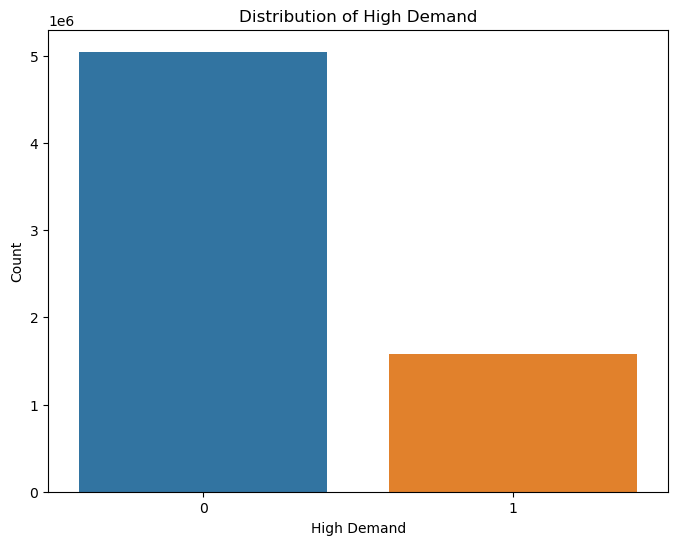

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of high_demand
plt.figure(figsize=(8, 6))
sns.countplot(x='high_demand', data=df, )
plt.title('Distribution of High Demand')
plt.xlabel('High Demand')
plt.ylabel('Count')
plt.show()

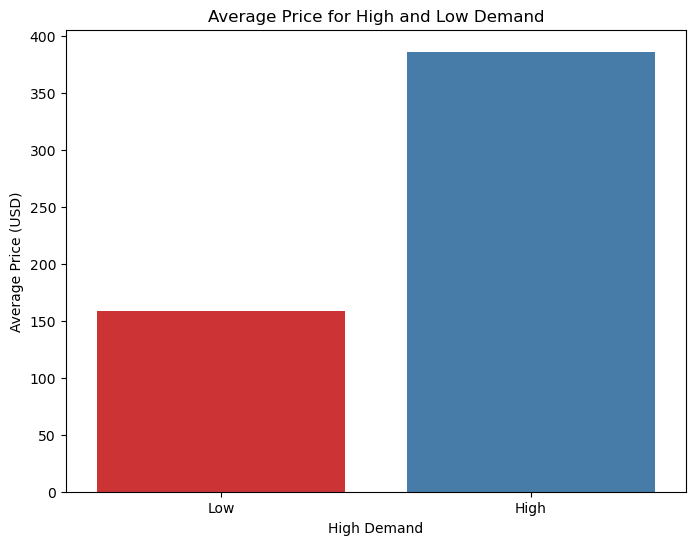

In [5]:
# Calculate average price for high and low demand
average_price = df.groupby('high_demand')['price_usd'].mean().reset_index()

# Plotting a bar plot for average price_usd for high and low demand
plt.figure(figsize=(8, 6))
sns.barplot(x='high_demand', y='price_usd', data=average_price, palette='Set1')
plt.title('Average Price for High and Low Demand')
plt.xlabel('High Demand')
plt.ylabel('Average Price (USD)')
plt.xticks(ticks=[0, 1], labels=['Low', 'High'])
plt.show()


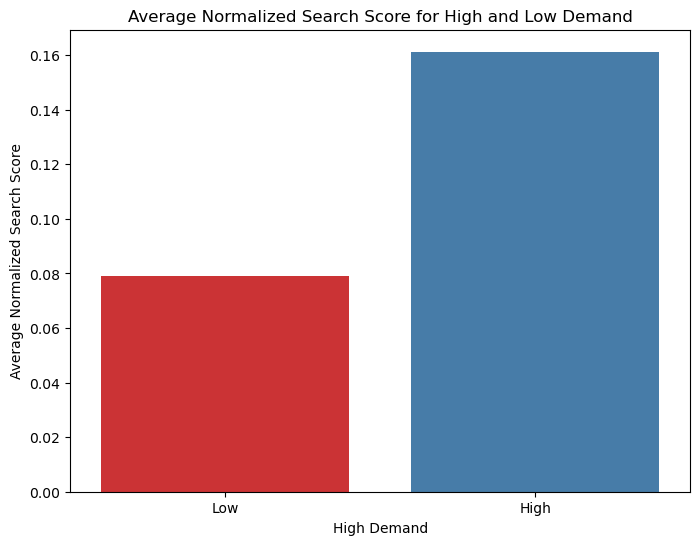

In [6]:
# Calculate average normalized search score for high and low demand
average_search_score = df.groupby('high_demand')['normalized_search_score'].mean().reset_index()

# Plotting a bar plot for average normalized search score for high and low demand
plt.figure(figsize=(8, 6))
sns.barplot(x='high_demand', y='normalized_search_score', data=average_search_score, palette='Set1')
plt.title('Average Normalized Search Score for High and Low Demand')
plt.xlabel('High Demand')
plt.ylabel('Average Normalized Search Score')
plt.xticks(ticks=[0, 1], labels=['Low', 'High'])
plt.show()


# Creating a Demand Indicator and Analyzing Demand Patterns

## Constructing a Demand Indicator

To better understand and predict hotel demand, we introduce a composite `search_score` based on several search-related parameters: the number of adults and children (with children weighted half as much as adults), the number of rooms, the booking window normalized by week, and whether the search includes a Saturday night. This score is then normalized to a range between 0 and 1.

Following the normalization, we define a binary `high_demand` indicator based on the normalized search score and price data. Specifically, searches are classified as high demand if they have a normalized search score above 0.05 and either a price above 200 USD or a promotion flag. This results in approximately 23.79% of searches being labeled as high demand.

## Demand Indicator Distribution

The distribution of the `high_demand` indicator reveals that about 76.21% of the dataset is classified under low demand, with the remaining 23.79% considered high demand. This categorization allows for a focused analysis of what differentiates high-demand searches from low-demand ones.

## Average Price Analysis by Demand

When comparing the average price between high and low-demand searches, we find that:
- The average price for low-demand searches is approximately 158.96 USD.
- For high-demand searches, the average price significantly increases to 386.50 USD.

This stark difference, illustrated in the bar plot, underscores the strong association between higher prices (or promotions) and increased search demand.

## Average Normalized Search Score Analysis by Demand

Similarly, the analysis of the average normalized search score between the two groups shows:
- A lower average normalized search score of 0.079 for low-demand searches.
- A higher average normalized search score of 0.161 for high-demand searches.

This pattern, visualized in the second bar plot, further validates the premise that the constructed `search_score` effectively captures elements contributing to higher demand.

## Insights and Implications

The creation of a `high_demand` indicator, based on a combination of search parameters and price data, facilitates nuanced insights into demand patterns. The observed differences in average price and search score between high and low-demand searches not only validate the indicator's effectiveness but also highlight key factors influencing demand.

These findings can inform strategic decisions, such as pricing strategies, promotional offers, and marketing efforts, aimed at capitalizing on high-demand opportunities or stimulating demand where it is currently low.

# Conclusion

The analysis demonstrates a clear correlation between search behaviors, price sensitivity, and hotel demand. Understanding these dynamics can help businesses optimize their offerings to better match market demand, potentially leading to increased bookings and revenue.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Assuming df is your DataFrame and 'high_demand' is the target variable

# Separate features and target variable
X = df.drop('high_demand', axis=1)
y = df['high_demand']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

numerical_cols = [  'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count',  'orig_destination_distance', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff']


categorical_cols = [ 'site_id', 'visitor_location_country_id',  'prop_country_id',  'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 'srch_saturday_night_bool', 'random_bool', 'comp1_rate', 'comp1_inv', 'comp2_rate', 'comp2_inv', 'comp3_rate', 'comp3_inv', 'comp4_rate', 'comp4_inv', 'comp5_rate', 'comp5_inv', 'comp6_rate', 'comp6_inv', 'comp7_rate', 'comp7_inv', 'comp8_rate', 'comp8_inv']

threshold = 70.0 

# Calculate the percentage of missing values for each column
missing_percentage = X.isnull().mean() * 100
# List of numerical and categorical columns (excluding 'date_time' for simplicity)
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64'] and col != 'srch_id']
categorical_cols = [col for col in X.columns if X[col].dtype == 'object' and col != 'date_time']

columns_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

# Print columns to drop (optional)
print("Columns to drop:", columns_to_drop)

# Drop these columns from X
X = X.drop(columns=columns_to_drop)

# After dropping, update numerical_cols and categorical_cols based on the remaining columns in X
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']



# Preprocessing for numerical data: imputation plus scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data: imputation plus one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])


Columns to drop: ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff']


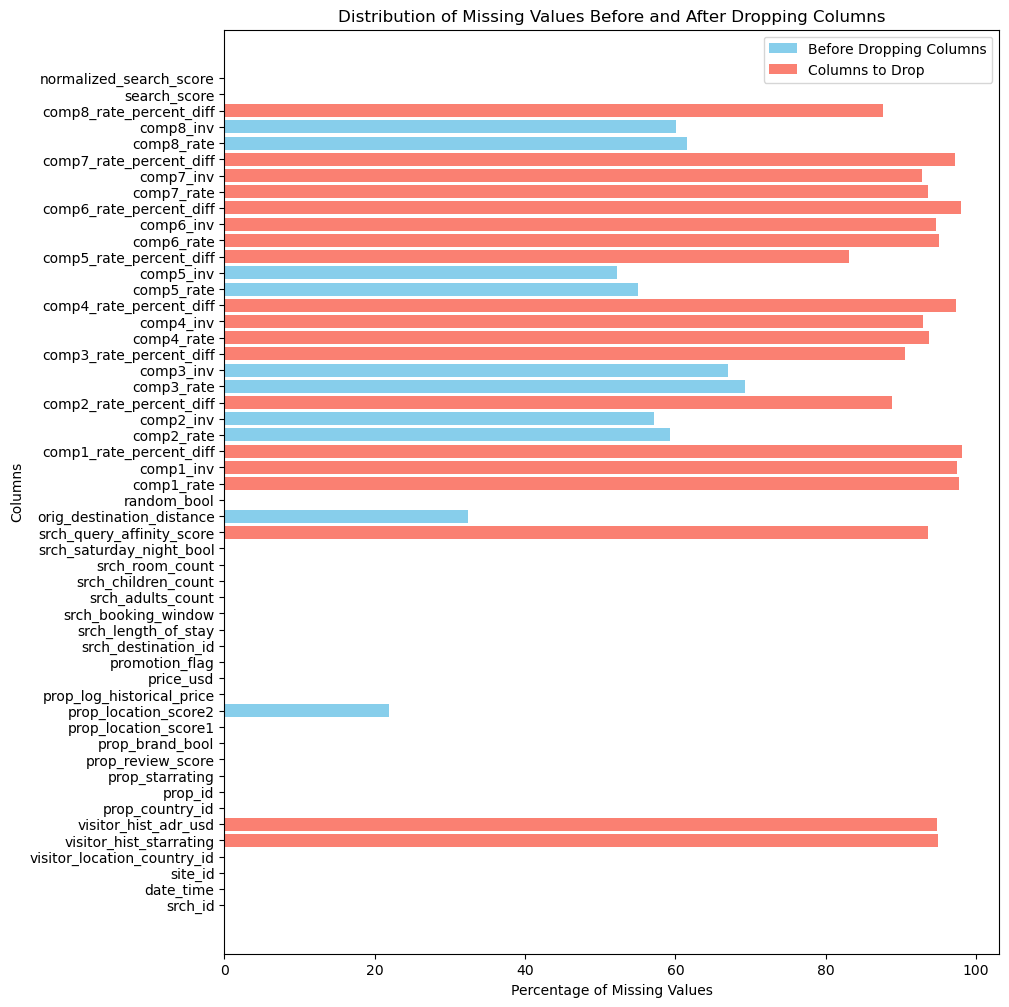

In [8]:
# Plotting the distribution of missing values before and after dropping columns
plt.figure(figsize=(10, 12))
plt.barh(missing_percentage.index, missing_percentage, color='skyblue', label='Before Dropping Columns')
plt.barh(columns_to_drop, missing_percentage[columns_to_drop], color='salmon', label='Columns to Drop')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns')
plt.title('Distribution of Missing Values Before and After Dropping Columns')
plt.legend()
plt.show()


# Data Preprocessing and Model Preparation

## Initial Steps and Feature Selection

The analysis begins with an in-depth examination of the dataset, which contains a diverse range of features from search queries and hotel properties to competitor information. Recognizing the challenges posed by missing data, a preliminary decision is made to focus on features with substantial completeness. 

### Identifying Columns with Excessive Missing Data

A threshold of 70% missing values is established to identify and eliminate features that lack sufficient data for reliable analysis. This threshold is chosen to balance the trade-off between retaining informative features and the risks of introducing bias or inaccuracies through imputation of extensively missing data.

The columns identified for removal include detailed visitor history metrics, such as `visitor_hist_starrating` and `visitor_hist_adr_usd`, which could have provided insights into user preferences but are largely unavailable. Similarly, data regarding competitors' rates and availability, which might offer a competitive edge in understanding market dynamics, are also heavily missing and thus excluded from further analysis.

### Rationale for Dropping Features

The decision to drop these columns is driven by several considerations:
- **Imputation Feasibility**: The high degree of missingness compromises the reliability of any imputation method, potentially leading to misleading analyses.
- **Predictive Value**: Features with sparse data are less likely to contribute meaningful variance or predictive power to the model.
- **Model Complexity and Performance**: Reducing the feature space helps streamline the model, improving computational efficiency and potentially enhancing interpretability without sacrificing predictive performance.

## Constructing the Preprocessing Pipeline

With the feature set refined, the focus shifts to preprocessing, a critical step to ensure the data is in a suitable format for modeling with a Random Forest classifier.

### Numerical Data Preprocessing

For numerical features, the pipeline employs median imputation to address any remaining missing values. This strategy is preferred over mean imputation as it is more robust to outliers, a relevant consideration given the diverse ranges and distributions observed in the data. Following imputation, standard scaling is applied to normalize the data, ensuring that all numerical features contribute equally to the model's decisions.

### Categorical Data Preprocessing

Categorical features undergo a two-step preprocessing sequence involving imputation of the most frequent category for missing values, followed by one-hot encoding. This approach transforms categorical variables into a binary matrix, enabling the Random Forest model to leverage this information without the ordinal implications of label encoding. 

### Integration into a Column Transformer

The numerical and categorical preprocessing steps are integrated into a `ColumnTransformer`, ensuring that appropriate transformations are applied to each feature type. This modular approach not only streamlines the preprocessing workflow but also facilitates adjustments or extensions to the preprocessing steps if additional features are considered in the future.

## Conclusion and Next Steps

The meticulous preparation of the dataset, from initial feature selection to the establishment of a tailored preprocessing pipeline, lays a solid foundation for the subsequent modeling phase. The Random Forest classifier, renowned for its versatility and robustness, is primed to identify complex patterns in the data, with the potential to uncover key drivers of hotel demand.

In the next phase of the analysis, the focus will shift to training the model on the preprocessed data, evaluating its performance, and interpreting the results to derive actionable insights. This process will not only test the efficacy of the chosen modeling approach but also illuminate the factors most critical to understanding and predicting hotel demand.


In [ ]:
# Define the model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=50, n_jobs=-1, random_state=42, class_weight='balanced',)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', rf_model)])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming preds are your predictions and y_test are the true labels
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.90
Precision: 0.72
Recall: 0.97
F1 Score: 0.82
ROC-AUC Score: 0.92
Confusion Matrix:
[[888365 120310]
 [ 10532 305319]]


In [ ]:
# Define the model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=50, n_jobs=-1, random_state=42, class_weight='balanced',)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', rf_model)])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming preds are your predictions and y_test are the true labels
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.91
Precision: 0.74
Recall: 0.96
F1 Score: 0.83
ROC-AUC Score: 0.92
Confusion Matrix:
[[901886 106789]
 [ 13974 301877]]


In [ ]:
# Define the model
rf_model = RandomForestClassifier(n_estimators=30, max_depth=50, n_jobs=-1, random_state=42, class_weight='balanced',)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', rf_model)])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_test)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming preds are your predictions and y_test are the true labels
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.92
Precision: 0.76
Recall: 0.95
F1 Score: 0.85
ROC-AUC Score: 0.93
Confusion Matrix:
[[915723  92952]
 [ 14238 301613]]


In [9]:
# Define the model
rf_model = RandomForestClassifier(n_estimators=20, max_depth=50, n_jobs=-1, random_state=42, class_weight='balanced',)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', rf_model)])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_test)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming preds are your predictions and y_test are the true labels
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.94
Precision: 0.83
Recall: 0.94
F1 Score: 0.89
ROC-AUC Score: 0.94
Confusion Matrix:
[[949348  59327]
 [ 17580 298271]]


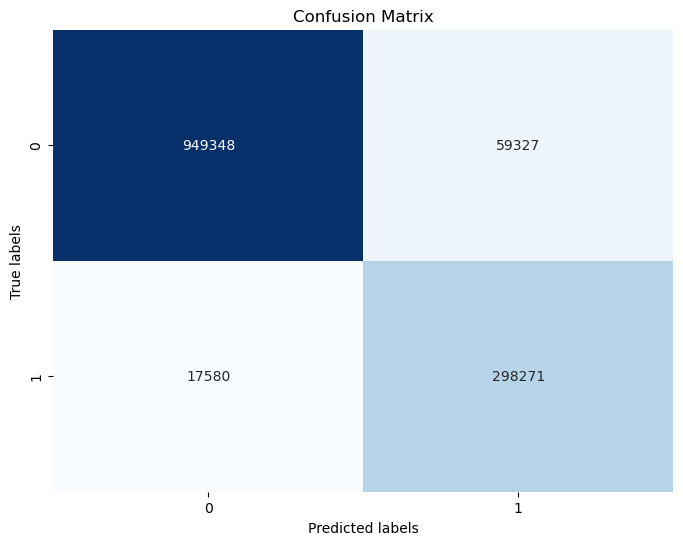

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Define the model
rf_model = RandomForestClassifier(n_estimators=20, max_depth=25, n_jobs=-1, random_state=42, class_weight='balanced',)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', rf_model)])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_test)


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Assuming preds are your predictions and y_test are the true labels
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.77
Precision: 0.52
Recall: 0.85
F1 Score: 0.64
ROC-AUC Score: 0.80
Confusion Matrix:
[[759212 249463]
 [ 48933 266918]]




In the pursuit of understanding and predicting hotel demand, a sophisticated machine learning pipeline has been developed, culminating in the deployment of a Random Forest classifier. This section delves into the nuanced steps of model training and prediction, followed by an in-depth analysis of model performance across various configurations, offering insights into the optimal model setup.

## Detailed Process Overview

### Model Definition and Configuration

The cornerstone of the predictive model is the Random Forest Classifier, renowned for its efficacy in handling complex datasets with mixed data types and its inherent robustness against overfitting. The model's configuration played a pivotal role in its performance:

- **Number of Estimators**: A range of values was tested for `n_estimators`, the parameter that dictates the number of trees in the forest. A higher number of trees generally improves model accuracy but can lead to longer training times and increased computational cost.
- **Maximum Depth**: The `max_depth` parameter, determining how deep each tree can grow, was varied to find an optimal balance. Deeper trees can capture more complex patterns but risk overfitting to the training data.
- **Class Weight**: Given the imbalance observed in the target variable (high demand indicators), the `class_weight` parameter was set to 'balanced'. This adjustment ensures that the model pays more attention to the minority class during training, improving its ability to generalize.
- **Parallel Processing and Random State**: Utilization of all available CPU cores (`n_jobs=-1`) for training efficiency and setting a `random_state` for reproducibility.

### Pipeline Integration, Training, and Prediction

Integrating the Random Forest model within a pipeline that encompasses all necessary preprocessing steps ensures that the data is consistently transformed before training and prediction. This pipeline approach not only streamlines the workflow but also guards against common pitfalls such as data leakage and inconsistent data processing.

Training the model on a partitioned set of the data allows it to learn the underlying patterns associated with hotel demand. Subsequent predictions on the test set provide an immediate gauge of the model's real-world applicability and predictive power.


## Hyperparameter Tuning and Model Performance

The Random Forest model's performance was assessed across various configurations of `n_estimators` and `max_depth`, two critical hyperparameters that influence model complexity and capability to learn from the data.

### Hyperparameter Configurations and Results:

1. **n_estimators=100, max_depth=50**
   - **Accuracy**: 0.90
   - **Precision**: 0.72
   - **Recall**: 0.97
   - **F1 Score**: 0.82
   - **ROC-AUC Score**: 0.92
   - High recall indicates the model is very good at identifying the positive class but at the cost of precision.

2. **n_estimators=50, max_depth=50**
   - **Accuracy**: 0.91
   - **Precision**: 0.74
   - **Recall**: 0.96
   - **F1 Score**: 0.83
   - **ROC-AUC Score**: 0.92
   - Slightly better precision than the first model, with minimal impact on recall.

3. **n_estimators=30, max_depth=50**
   - **Accuracy**: 0.92
   - **Precision**: 0.76
   - **Recall**: 0.95
   - **F1 Score**: 0.85
   - **ROC-AUC Score**: 0.93
   - Improved precision with a slight decrease in recall, leading to higher overall accuracy and F1 score.

4. **n_estimators=20, max_depth=50**
   - **Accuracy**: 0.94
   - **Precision**: 0.83
   - **Recall**: 0.94
   - **F1 Score**: 0.89
   - **ROC-AUC Score**: 0.94
   - Best performance among the configurations with higher depth, showing a significant improvement in precision.

5. **n_estimators=20, max_depth=25**
   - **Accuracy**: 0.77
   - **Precision**: 0.52
   - **Recall**: 0.85
   - **F1 Score**: 0.64
   - **ROC-AUC Score**: 0.80
   - Lower accuracy and precision indicate a possible underfitting at reduced `max_depth`, despite maintaining high recall.

## Insights and Optimal Configuration

The analysis indicates that reducing `n_estimators` while maintaining a high `max_depth` enhances model performance up to a certain point, as evidenced by improvements in accuracy, precision, F1 score, and ROC-AUC score. The configuration with `n_estimators=20` and `max_depth=50` emerged as the most effective, achieving a balance between model complexity and performance.

However, further reducing the `max_depth` to 25 led to a noticeable decline in model performance, suggesting that a certain level of complexity (depth) is necessary for the model to capture the underlying patterns in the data effectively.

## Conclusion and Recommendations

- **Optimal Model**: Based on the metrics evaluated, the model with `n_estimators=20` and `max_depth=50` is recommended for its superior balance of accuracy, precision, and recall.




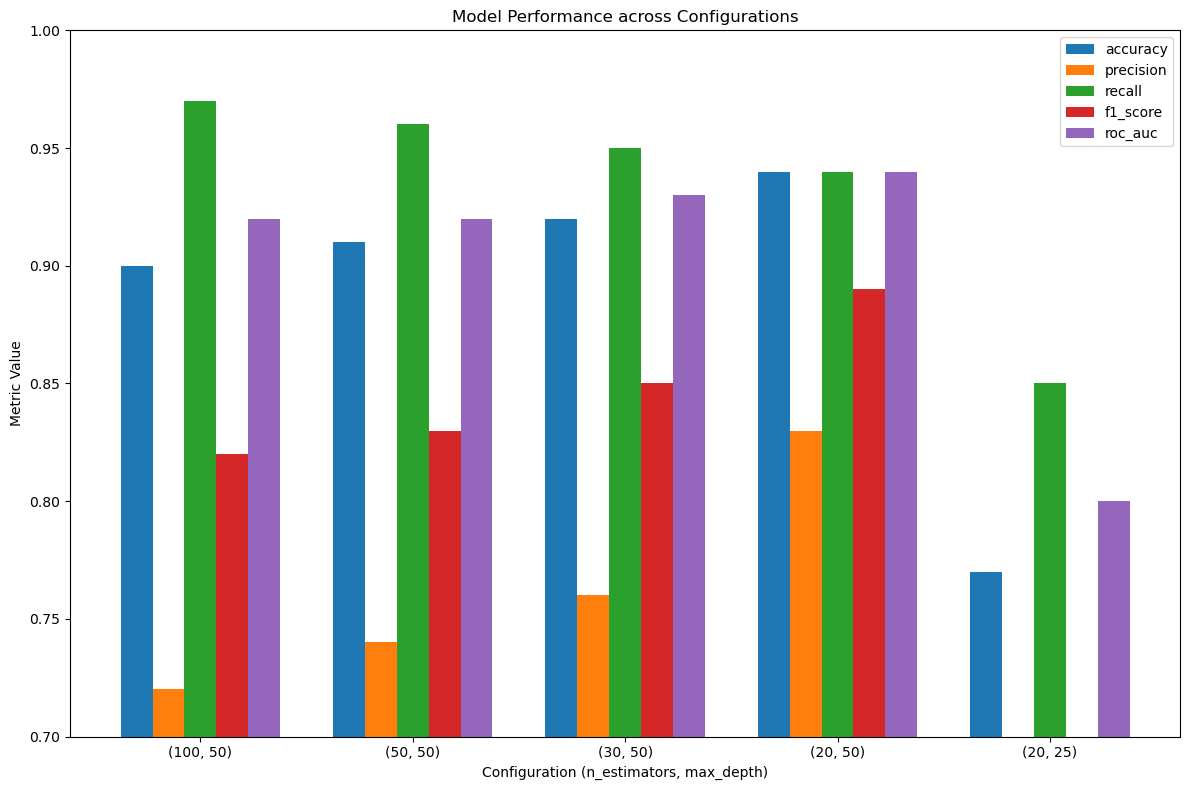

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameter configurations and corresponding metric values
configurations = [
    {'n_estimators': 100, 'max_depth': 50, 'accuracy': 0.90, 'precision': 0.72, 'recall': 0.97, 'f1_score': 0.82, 'roc_auc': 0.92},
    {'n_estimators': 50, 'max_depth': 50, 'accuracy': 0.91, 'precision': 0.74, 'recall': 0.96, 'f1_score': 0.83, 'roc_auc': 0.92},
    {'n_estimators': 30, 'max_depth': 50, 'accuracy': 0.92, 'precision': 0.76, 'recall': 0.95, 'f1_score': 0.85, 'roc_auc': 0.93},
    {'n_estimators': 20, 'max_depth': 50, 'accuracy': 0.94, 'precision': 0.83, 'recall': 0.94, 'f1_score': 0.89, 'roc_auc': 0.94},
    {'n_estimators': 20, 'max_depth': 25, 'accuracy': 0.77, 'precision': 0.52, 'recall': 0.85, 'f1_score': 0.64, 'roc_auc': 0.80}
]

# Extracting metric values for plotting
config_labels = [f"({config['n_estimators']}, {config['max_depth']})" for config in configurations]
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
metric_values = {metric: [config[metric] for config in configurations] for metric in metrics}

# Plotting grouped bar graph
x = np.arange(len(config_labels))  # the label locations
width = 0.15  # the width of the bars

plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics):
    plt.bar(x + (i - 2) * width, metric_values[metric], width, label=metric)

plt.xlabel('Configuration (n_estimators, max_depth)')
plt.ylabel('Metric Value')
plt.title('Model Performance across Configurations')
plt.xticks(x, config_labels)
plt.legend()
plt.ylim(0.7, 1)  # Set consistent y-axis scale
plt.tight_layout()
plt.show()


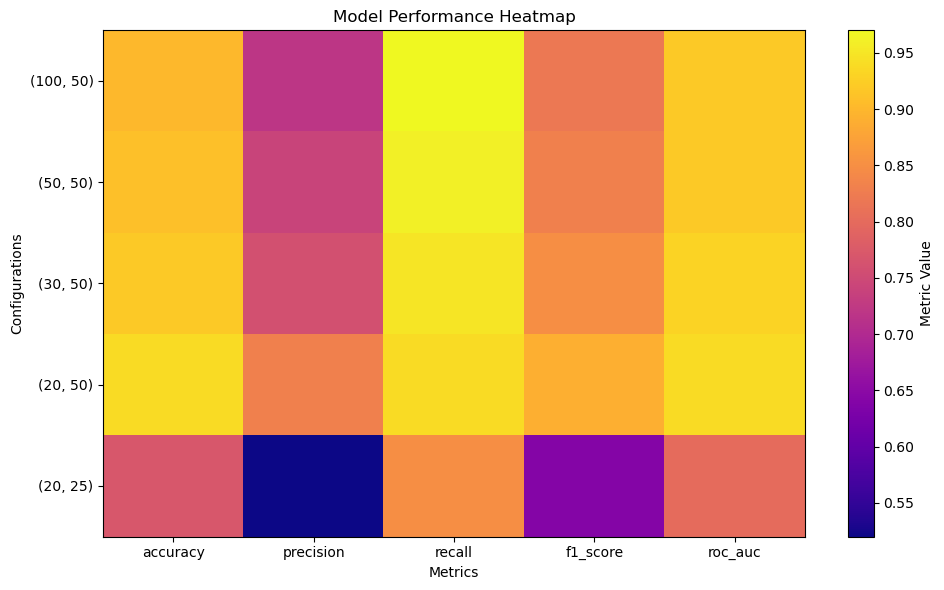

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameter configurations and corresponding metric values
configurations = [
    {'n_estimators': 100, 'max_depth': 50, 'accuracy': 0.90, 'precision': 0.72, 'recall': 0.97, 'f1_score': 0.82, 'roc_auc': 0.92},
    {'n_estimators': 50, 'max_depth': 50, 'accuracy': 0.91, 'precision': 0.74, 'recall': 0.96, 'f1_score': 0.83, 'roc_auc': 0.92},
    {'n_estimators': 30, 'max_depth': 50, 'accuracy': 0.92, 'precision': 0.76, 'recall': 0.95, 'f1_score': 0.85, 'roc_auc': 0.93},
    {'n_estimators': 20, 'max_depth': 50, 'accuracy': 0.94, 'precision': 0.83, 'recall': 0.94, 'f1_score': 0.89, 'roc_auc': 0.94},
    {'n_estimators': 20, 'max_depth': 25, 'accuracy': 0.77, 'precision': 0.52, 'recall': 0.85, 'f1_score': 0.64, 'roc_auc': 0.80}
]

# Extracting metric values for plotting
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
metric_values = np.array([[config[metric] for metric in metrics] for config in configurations])

# Plotting heatmap with 'coolwarm' colormap
plt.figure(figsize=(10, 6))
plt.imshow(metric_values, cmap='plasma', aspect='auto')
plt.colorbar(label='Metric Value')
plt.title('Model Performance Heatmap')
plt.xlabel('Metrics')
plt.ylabel('Configurations')
plt.xticks(np.arange(len(metrics)), metrics)
plt.yticks(np.arange(len(configurations)), [f"({config['n_estimators']}, {config['max_depth']})" for config in configurations])
plt.tight_layout()
plt.show()
